In [187]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [188]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0],bias=False)
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1],bias=False))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size,bias=False)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [189]:
INPUT_SIZE=784
HIDDEN_SIZES=[500,300,100]
OUTPUT_SIZE=10
BATCH_SIZE=100
LEARNING_RATE=0.01
NUM_EPOCHS=50

M_TRAIN=10000
M_VAL=2000

In [190]:
# Import the MNIST dataset as two separate datasets

train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

validation_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

reduced_train_index=list(range(M_TRAIN))
reduced_test_index=list(range(M_VAL))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_validation_dataset=Subset(validation_dataset, reduced_test_index)

# Create the data loader for training
train_dataset_loader = DataLoader(subset_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the data loader for validating

validation_dataset_loader = DataLoader(subset_validation_dataset, batch_size=BATCH_SIZE, shuffle=False) 

In [191]:
def strat_sample(train_dataset):

    train_stratified_sample=[0,0,0,0,0,0,0,0,0,0]
    unidentified_label=[0,1,2,3,4,5,6,7,8,9]

    counter=np.random.randint(0,1000)
    while len(unidentified_label)>0:
        label=train_dataset[counter][1]
        if label in unidentified_label:
            unidentified_label.remove(label)
            train_stratified_sample[label]=counter
        counter+=1
    return train_stratified_sample

strat_loader_1 = DataLoader(dataset=Subset(train_dataset,strat_sample(train_dataset)))
strat_loader_2 = DataLoader(dataset=Subset(train_dataset,strat_sample(train_dataset)))

In [192]:
def stiffness(x_1,x_2):
    return np.dot(x_1/norm(x_1),x_2/norm(x_2))

In [193]:
model=NeuralNet(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
ReLU_glorot_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

def train_epoch():
    class_gradients_1=[]
    for image, label in strat_loader_1:
        image = image.reshape(-1,28*28)
        output=model(image)
        optimizer.zero_grad()
        loss1=criterion(output,label)
        loss1.backward()

        gradient=[]
        gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        for layer in model.hidden:
            gradient+=torch.flatten(layer.weight.grad).tolist()
        gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        class_gradients_1.append(np.array(gradient))

    class_gradients_2=[]
    for image, label in strat_loader_2:
        image = image.reshape(-1,28*28)
        output=model(image)
        optimizer.zero_grad()
        loss1=criterion(output,label)
        loss1.backward()

        gradient=[]
        gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        for layer in model.hidden:
            gradient+=torch.flatten(layer.weight.grad).tolist()
        gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        class_gradients_2.append(np.array(gradient))
    
    stiffness_matrix=np.zeros((OUTPUT_SIZE,OUTPUT_SIZE))
    for n, x_1 in enumerate(class_gradients_1):
        for m, x_2 in enumerate(class_gradients_2):
            stiffness_matrix[n][m]=stiffness(x_1,x_2)

    for images, labels in train_dataset_loader:  
        images = images.reshape(-1, 28*28)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), stiffness_matrix


stiff_matrices=[]
for n in range(NUM_EPOCHS):
    loss, stiff_matrix=train_epoch()
    stiff_matrices.append(stiff_matrix)
    print(loss)

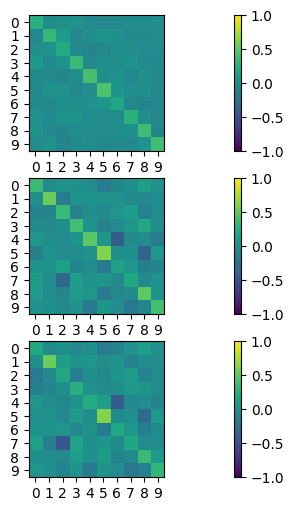

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=1,nrows=3, figsize=(18,6))
p1 = ax1.imshow(stiff_matrices[0],vmin=-1,vmax=1)
p2 = ax2.imshow(stiff_matrices[10],vmin=-1,vmax=1)
p3 = ax3.imshow(stiff_matrices[-1],vmin=-1,vmax=1)
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax3.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax1.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax3.set_yticks([0,1,2,3,4,5,6,7,8,9])
fig.colorbar(p1,ax=ax1)
fig.colorbar(p2,ax=ax2)
fig.colorbar(p3,ax=ax3)

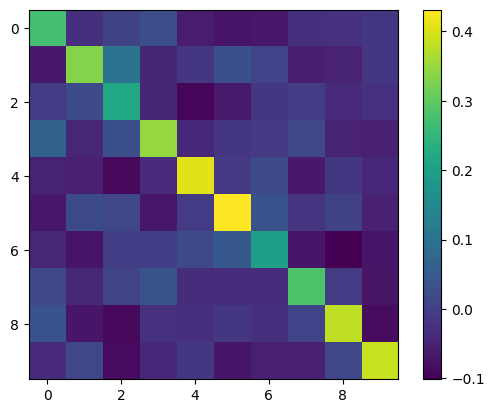

In [ ]:
def strat_sample(train_dataset, samples_per_cat):

    train_stratified_sample=[[],[],[],[],[],[],[],[],[],[]]
    unidentified_label=[0,1,2,3,4,5,6,7,8,9]
    cat_counts=[0,0,0,0,0,0,0,0,0,0]

    counter=0
    while len(unidentified_label)>0:
        label=train_dataset[counter][1]
        if label in unidentified_label:
            train_stratified_sample[label].append(counter)
            cat_counts[label]+=1
            if cat_counts[label]==samples_per_cat:
                unidentified_label.remove(label)
        counter+=1
    return train_stratified_sample

average_ouputs=[]

for list_indicies in strat_sample(train_dataset,500):
    loader=DataLoader(dataset=Subset(train_dataset,list_indicies),batch_size=len(list_indicies))
    for images,labels in loader:
        images=images.reshape(-1,28*28)
        output=model(images)
    average_ten=torch.zeros(10)
    for ten in output:
        average_ten+=ten/500
    average_ouputs.append(average_ten.detach().numpy())

fig, (ax1) = plt.subplots(1,1)
p1 = ax1.imshow(stiff_matrices[0])
fig.colorbar(p1,ax=ax1)